# Selection, operation and control of a pump

This jupyter notebook shows how to develop the system curve and subsequently select and operate the pump for the system shown in the following picture.

### Preliminary settings

Import the required python libs for this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define some settings to be compatible with colorblind people 

In [2]:
import matplotlib.pyplot as plt
N = 6
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
linestyles = ['-','--','-.',':']

## Part I: Definition of the system

### Definition of the system

Physical constants and material properties of the fluid

In [3]:
g = 9.81                               # gravity [m/s²]
nu = 0.801*10**(-6)                    # kinematic vicosity [m²/s]
rho = 996.1                            # density [kg/m³]

System properties: geometry

In [4]:
H_geo = 3                              # geodetic head [m]
D_suction = 0.1317                     # pipe diameter suction side DN 150 (ISO 6708) [m]
D_press = 0.107                        # pipe diameter pressure side DN 100 (ISO 6708) [m]
l_suction = 5.9                        # pipe length suction side [m]
l_press = 9.74                         # pipe length suction side [m]

System curve properties: local loss coeffcients suction side

In [5]:
k_flange = 0.2                         # flange
k_valve = 0.15                         # gate valve (fully opened)
k_anemo = 0.3                          # flow rate sensor 
k_nozzle = 0.2                         # air inlet nozzle

System curve properties: local loss coefficients pressure side

In [6]:
k_bows = 0.9                           # elbow losses
k_throttle_valve = 21                  # open throttle values

System curve properties: friction losses (fully turbulent (Nikuradse equation))

In [7]:
epsilon = 0.05*10**(-3)
lambda_suction = (1/(2*np.log10(3.71*D_suction/epsilon)))**2
lambda_press = (1/(2*np.log10(3.71*D_press/epsilon)))**2
print('lambda suction pide: ', lambda_suction)
print('lambda press pide: ', lambda_press)

lambda suction pide:  0.015703500179516654
lambda press pide:  0.016438344665072872


### Operation conditions

In [8]:
Q_design = 0.02                          # design flow rate
Q_operation = np.linspace(0,0.04,100)    # Volume flow rate [m³/s]

### Calculate the system head

Calculate the flow properties

In [9]:
v_suction = 4*Q_design/(np.pi*D_suction**2)
v_press = 4*Q_design/(np.pi*D_press**2)
Re_suction = v_suction*D_suction/nu
Re_press = v_press*D_press/nu
print('Reynolds number suction pide: ', Re_suction)
print('Reynolds number pressure pide: ', Re_press)

Reynolds number suction pide:  241391.41652569117
Reynolds number pressure pide:  297114.48183582735


Calculate the losses

In [10]:
H_losses_suction = v_suction**2/(2*g)*(6*k_flange+k_valve+k_anemo+k_nozzle+lambda_suction*l_suction/D_suction)
H_losses_press = v_press**2/(2*g)*(9*k_flange+2*k_bows+k_throttle_valve+lambda_press*l_press/D_press)
print('Head loss suction system: ', H_losses_suction)
print('Head loss pressure system: ', H_losses_press)

Head loss suction system:  0.28052631176419657
Head loss pressure system:  6.579999906432471


Bernoulli equation:

In [14]:
H_design = H_geo + v_press**2/(2*g) + H_losses_press
print('System Head: ', H_design)

System Head:  9.832142441412214


### Calculate and plot the system curve: $H = H_{geo} + K\cdot Q^2$

In [15]:
K=(H_design-H_geo)/Q_design**2
print('System curve equation: H = %0.2f + %0.2f Q²' %(H_geo, K))

System curve equation: H = 3.00 + 17080.36 Q²


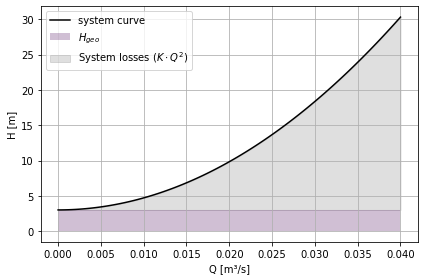

In [16]:
H = H_geo + K*Q_operation**2
plt.figure(1)
plt.plot(Q_operation, H, 'k', label='system curve')
plt.fill([0, np.max(Q_operation),np.max(Q_operation),0],[0,0, H_geo, H_geo], label='$H_{geo}$', alpha=0.25)
plt.fill_between(Q_operation,np.ones(len(H))*H_geo, H, label='System losses ($K\cdot Q^2$)', alpha=0.25, color='grey')
plt.xlabel('Q [m³/s]')
plt.ylabel('H [m]')
plt.grid('major')
plt.legend()
plt.tight_layout()

## Part II:  Check the impact of the throttle valve on the system curve

A throttle valve will create higher pressure losses in the system by raising the local losses in the valve given by the K-factor. The schemaatic of the system looks like this:

## Warning! Never use any throttle valve on the suction side of your system as it will cause cavitation on your pump!

### Define throttle values 

Five values from 'open' (k=21) to '80% closed' (k=105). The values for the closed valve are arbitrarily chosen

In [17]:
k_throttle_valve = np.linspace(21, 105, 5, endpoint=True)

### Recalculate the losses and system curve changes and plot the system curve changes

In [18]:
H_losses_press = v_press**2/(2*g)*(9*k_flange+2*k_bows+k_throttle_valve+lambda_press*l_press/D_press)
print('Head loss pressure system at Q_design with throttle: \n', H_losses_press)

Head loss pressure system at Q_design with throttle: 
 [ 6.57999991 11.87499314 17.16998638 22.46497961 27.75997284]


In [19]:
H_design = H_geo + v_press**2/(2*g) + H_losses_press
print('System Heads at Q_design with throttle: ', H_design)

System Heads at Q_design with throttle:  [ 9.83214244 15.12713568 20.42212891 25.71712215 31.01211538]


In [20]:
K = [(H_d-H_geo)/Q_design**2 for H_d in H_design]
print('K-values in the system curve: \n', K)

K-values in the system curve: 
 [17080.356103530536, 30317.839189967053, 43555.32227640356, 56792.80536284008, 70030.2884492766]


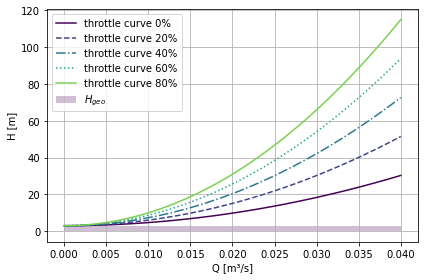

In [21]:
plt.figure(2)
for i,k in enumerate(K):
    H = H_geo + k*Q_operation**2
    plt.plot(Q_operation, H, linestyle=linestyles[i%4], label='throttle curve %d%%'%(20*i))
plt.fill([0, np.max(Q_operation),np.max(Q_operation),0],[0,0, H_geo, H_geo], label='$H_{geo}$', alpha=0.25)
plt.xlabel('Q [m³/s]')
plt.ylabel('H [m]')
plt.grid('major')
plt.legend()
plt.tight_layout()

The throttle does not affect the geodetic head!

## Part III: Select a pump for your system

<div>
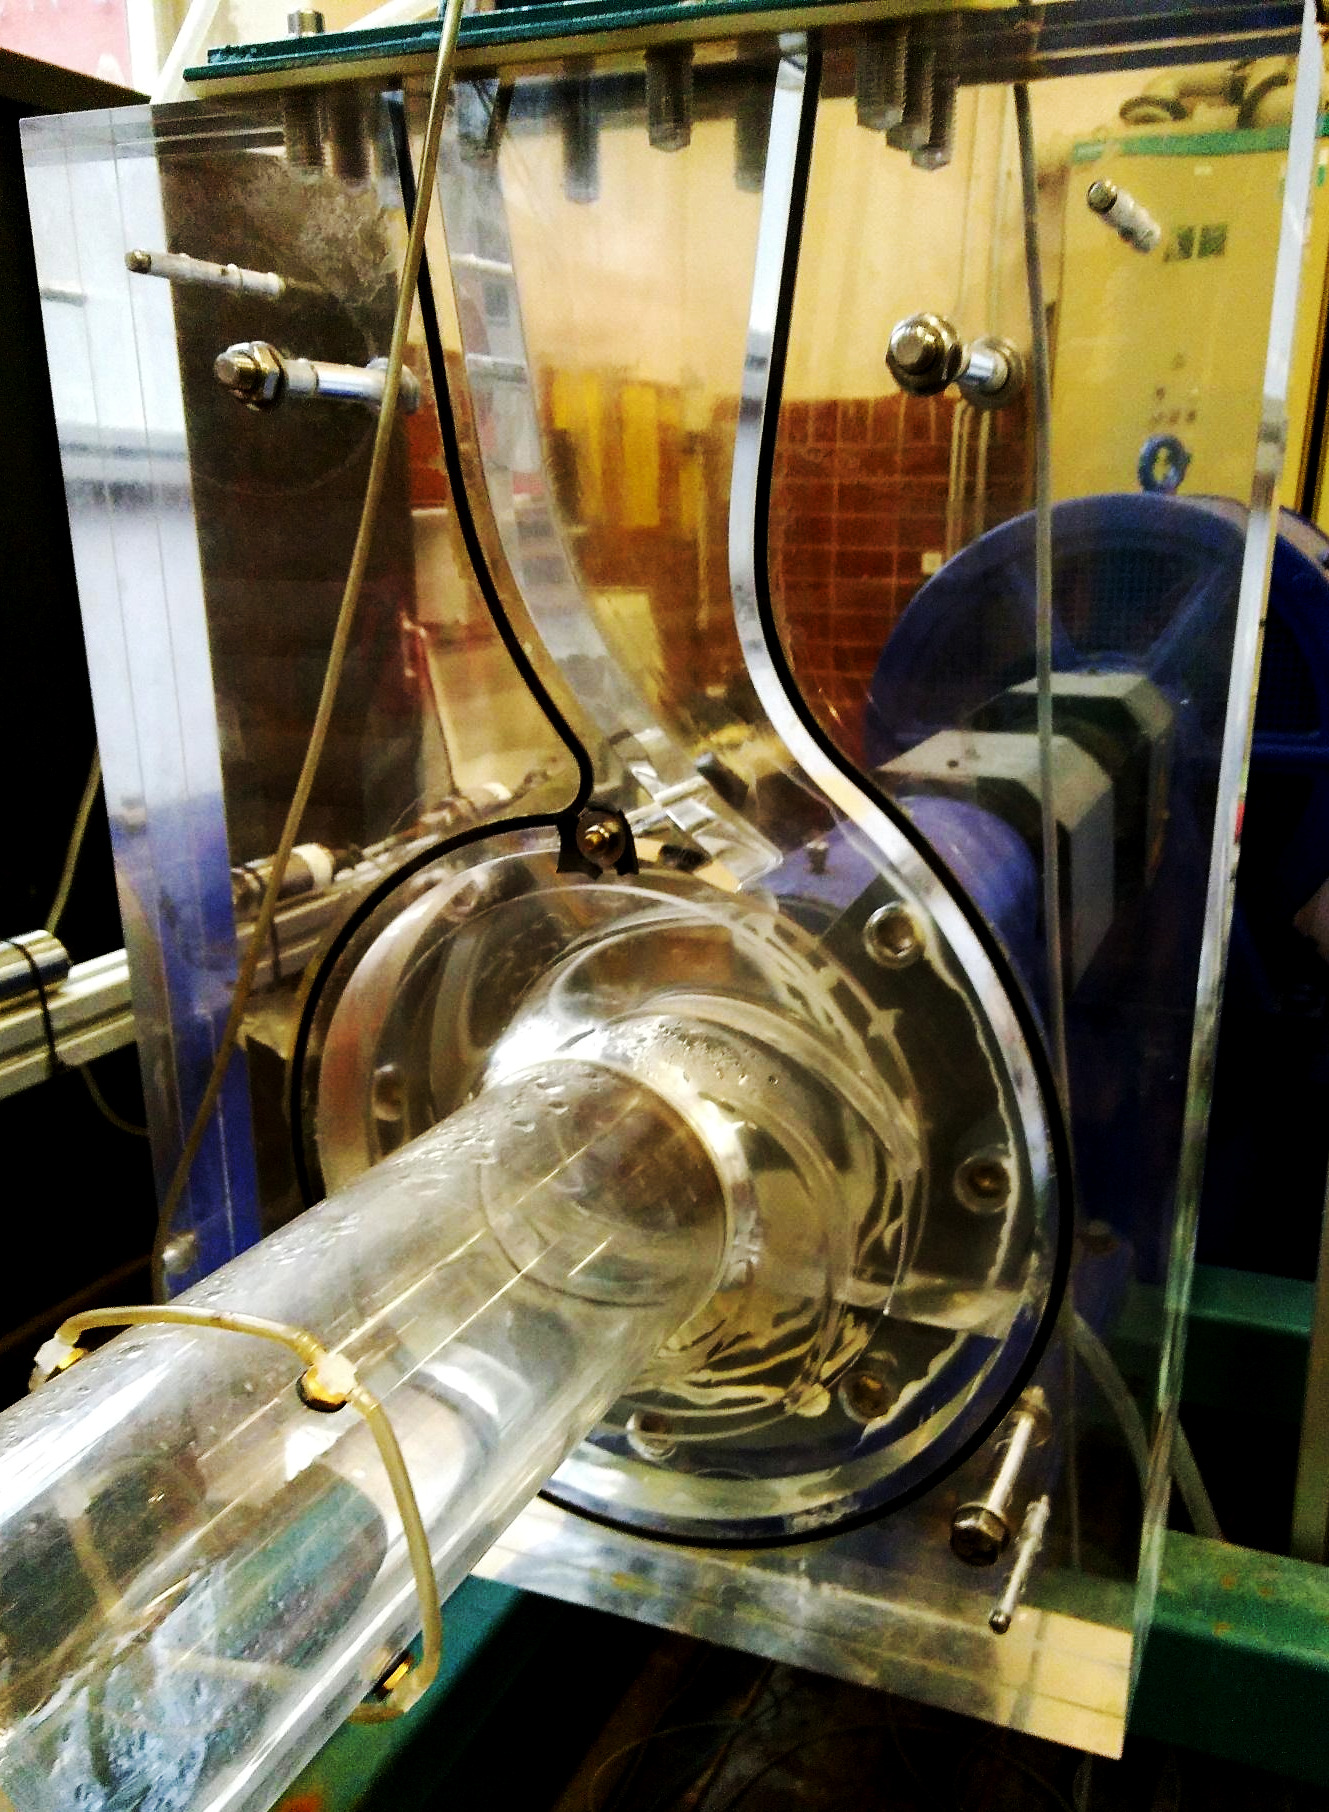
</div>
